## Constrained Bayesian Optimization
In this tutorial we demonstrate the use of Xopt to preform Bayesian Optimization on a
 simple test problem subject to a single constraint.

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize the sin
function in the domian [0,2*pi], subject to a cos constraining function.

In [1]:
import time

from xopt.vocs import VOCS
import math

# define variables, function objective and constraining function
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
    constraints={"c": ["LESS_THAN", 0]}
)

In [2]:
# define a test function to optimize
import numpy as np

def test_function(input_dict):
    return {"f": np.sin(input_dict["x"]),"c": np.cos(input_dict["x"])}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Upper Confidence Bound acquisition function to perform Bayesian Optimization.

In [3]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt import Xopt

evaluator = Evaluator(function=test_function)
generator = UpperConfidenceBoundGenerator(vocs=vocs)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [4]:
# call X.random_evaluate() to generate + evaluate 3 initial points
X.random_evaluate(2)

# inspect the gathered data
X.data

,x,f,c,xopt_runtime,xopt_error
1,0.128974,0.128617,0.991694,0.000015,False
2,2.105840,0.860246,-0.509879,0.000002,False


## Do bayesian optimization steps
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

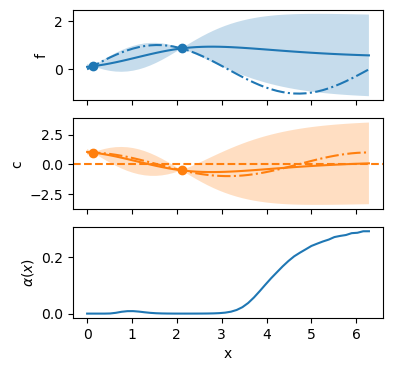

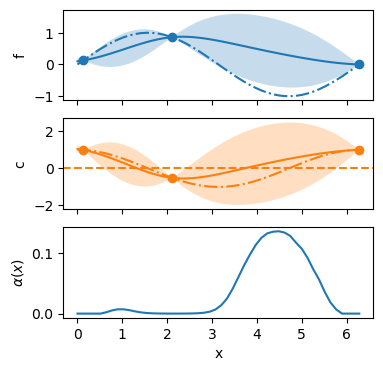

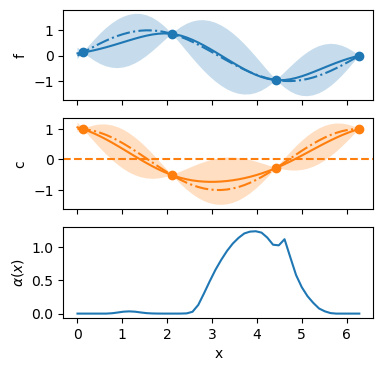

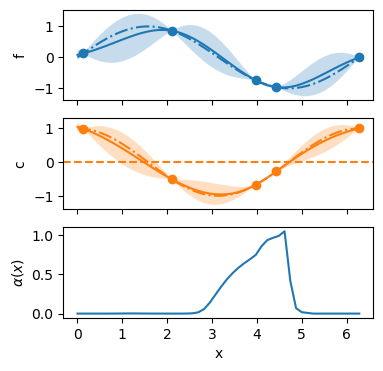

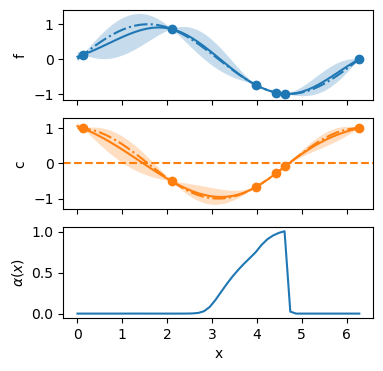

In [6]:
import time
from xopt.utils import visualize_model

n_steps = 5

# test points for plotting
test_x = np.linspace(*X.vocs.bounds.flatten(), 50)

for i in range(n_steps):
    start = time.perf_counter()
    fig,ax = visualize_model(X.generator)
    print(time.perf_counter() - start)

    # add ground truth functions to plots
    out = test_function({"x": test_x})
    ax[0].plot(test_x, out["f"], "C0-.",label="Ground truth")
    ax[1].plot(test_x, out["c"], "C1-.")

    ax[0].legend()

    # do the optimization step
    X.step()


In [ ]:
# access the collected data
X.data